In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw



Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



SAMPLE AT INDEX 0
LABEL: 5


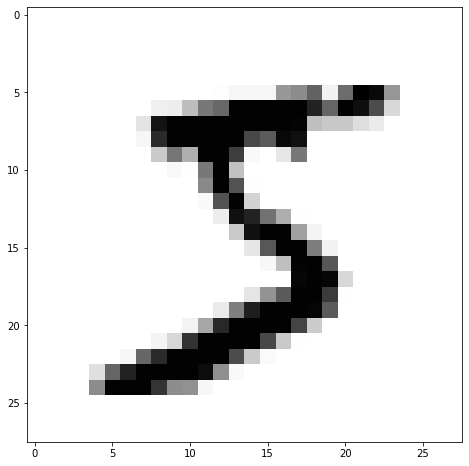

In [3]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

In [4]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [5]:
class ImageDataset(Dataset):

  def __init__(self, dataset, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform

    # Get x and y values from each line and append to self.data

    self.data = []
    to_tensor = torchvision.transforms.ToTensor()
    for d in dataset:
      image = d[0]
      label = d[1]
      image = to_tensor(image)
      image = torch.reshape(image, (-1,))
      label = torch.tensor(label).long()
      self.data.append(image)

    # Now self.data contains all our dataset.
    # Each element of the list self.data is a tuple: (input, output)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    
    sample = self.data[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample

In [6]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return (tensor + torch.randn(tensor.size()) * self.std + self.mean, tensor)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [7]:
torch.manual_seed(0)
composed_transform = transforms.Compose([AddGaussianNoise(0., 1.)])

train_size = int(len(train_dataset) * 0.8) #Train-validation 80-20 

train_idxs = range(0, train_size)
val_idxs = range(train_size, len(train_dataset))

full_dataset = ImageDataset(train_dataset, transform=composed_transform) #Dataset withouth validation set extracted
train_dataset = torch.utils.data.Subset(full_dataset, train_idxs) #Train dataset
validation_dataset = torch.utils.data.Subset(full_dataset, val_idxs) #Validation Dataset
test_dataset = ImageDataset(test_dataset, transform=composed_transform) #Test Dataset

In [8]:
batch_size = 100
test_batch = len(test_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=0)

In [9]:
class AutoEncoder(nn.Module):
    
    def __init__(self, H1 = 400, H2 = 120):
        super().__init__()
        self.fc1 = nn.Linear(784, H1)
        self.fc2 = nn.Linear(H1, H2)
        self.fc3 = nn.Linear(H2, H1)
        self.fc4 = nn.Linear(H1, 784)
        self.act = nn.ReLU()
        self.sig = nn.Sigmoid()
        
        print('Network initialized')
        
    def forward(self, x):
        x = self.act(self.fc1(x)) 
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x)) 
        x = self.sig(self.fc4(x))
        return x

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [11]:
torch.manual_seed(0)
net = AutoEncoder()
net = net.to(device)

Network initialized


In [12]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [13]:
### TRAINING LOOP
num_epochs = 30
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
  print('#################')
  print(f'# EPOCH {epoch_num}')
  print('#################')

  ### TRAIN
  train_loss= []
  net.train() # Training mode (e.g. enable dropout)
  for sample_batched in train_dataloader:
    # Move data to device
    x_train = sample_batched[0].to(device)
    y_train = sample_batched[1].to(device)

    # Forward pass
    out = net(x_train)

    # Compute loss
    loss = loss_function(out, y_train)

    # Backpropagation
    net.zero_grad()
    loss.backward()

    # Update the weights
    optimizer.step()

    # Save train loss for this batch
    loss_batch = loss.detach().cpu().numpy()
    train_loss.append(loss_batch)

  # Save average train loss
  train_loss = np.mean(train_loss)
  print(f"AVERAGE TRAIN LOSS: {train_loss}")
  train_loss_log.append(train_loss)

  ### VALIDATION
  val_loss = []
  net.eval() # Evaluation mode (e.g. disable dropout)
  with torch.no_grad(): # Disable gradient tracking
    for sample_batched in val_dataloader:
      # Move data to device
      x_val = sample_batched[0].to(device)
      y_val = sample_batched[1].to(device)
      # Forward pass
      output = net(x_val)

      # Compute loss
      loss = loss_function(output, y_val)

      # Save val loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      val_loss.append(loss_batch)

    # Save average validation loss
    val_loss = np.mean(val_loss)
    print(f"AVERAGE VAL LOSS: {val_loss}")
    val_loss_log.append(val_loss)
    

#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 0.0486934557557106
AVERAGE VAL LOSS: 0.035084716975688934
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 0.032615046948194504
AVERAGE VAL LOSS: 0.030709754675626755
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 0.029910994693636894
AVERAGE VAL LOSS: 0.02929059788584709
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 0.02856859751045704
AVERAGE VAL LOSS: 0.028187891468405724
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 0.027764979749917984
AVERAGE VAL LOSS: 0.027399078011512756
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 0.027213048189878464
AVERAGE VAL LOSS: 0.027136582881212234
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 0.026730524376034737
AVERAGE VAL LOSS: 0.026705434545874596
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 0.026353338733315468
AVERAGE VAL LOSS: 0.026365755125880

Noised
ORIGINAL
Recostructed


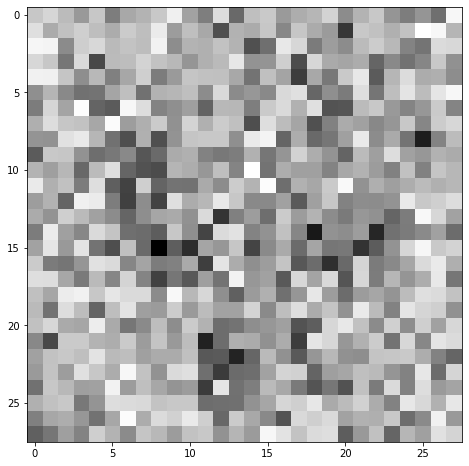

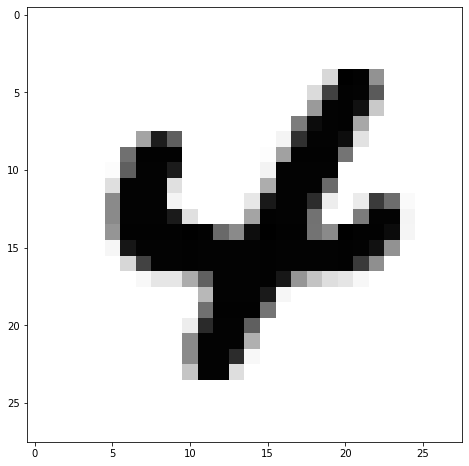

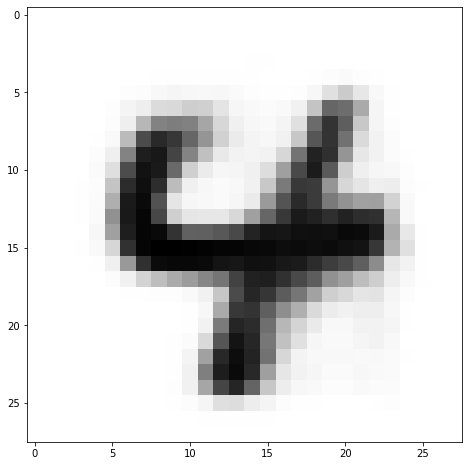

In [14]:
little_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)

for batch in little_dataloader:
  noised = batch[0].to(device)
  original = batch[1].to(device)
  sig = nn.Sigmoid()
  output = net(noised)
  output = torch.reshape(output, (28, 28))
  original = torch.reshape(original, (28, 28))
  noised = torch.reshape(noised, (28, 28))
  fig = plt.figure(figsize=(8,8))
  plt.imshow(noised.cpu().detach().numpy(), cmap='Greys')
  print("Noised")
  fig = plt.figure(figsize=(8,8))
  plt.imshow(original.cpu().detach().numpy(), cmap='Greys')
  print("ORIGINAL")
  
  fig = plt.figure(figsize=(8,8))
  plt.imshow(output.cpu().detach().numpy(), cmap='Greys')
  print("Recostructed")
  break